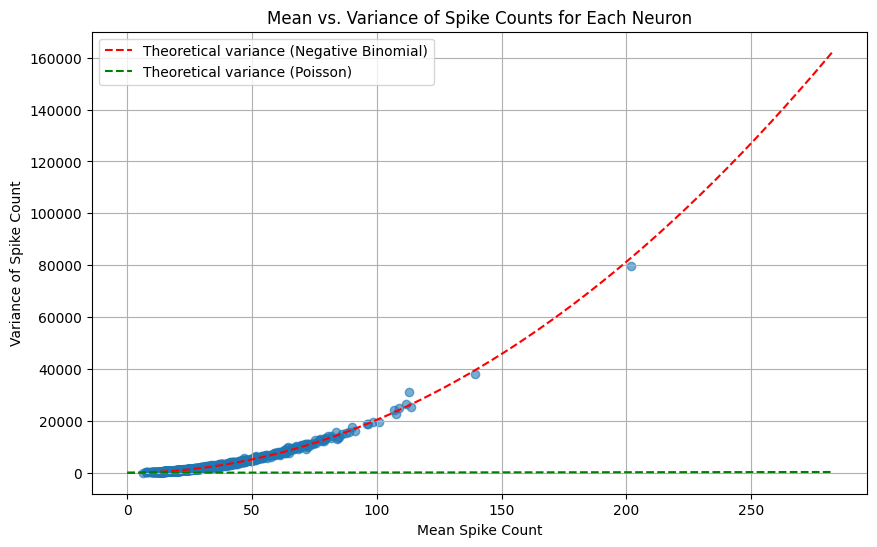

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)  # For reproducibility

# Parameters
n_neurons = 1000  # Number of neurons
n_obs = 500  # Number of observations (different stimulus intensities)

# Stimulus variable: Light intensity ranging from 0 (no light) to 10 (maximum intensity)
light_intensity = np.linspace(0, 10, n_obs)

# Define relationship for expected spike count
# Assume the mean spike count increases linearly with the intensity of the light
beta_0 = 0  # Baseline spike count when there is no light
beta_1 = 0.5  # Increase in spike count for each unit increase in light intensity

# Define the dispersion parameter for the negative binomial distribution
dispersion = 5 # This affects the variance of the spike counts

spike_counts = np.zeros((n_neurons, n_obs))

for i in range(n_neurons):
    individual_effect = np.random.normal(0, 0.5)  # Random effect for each neuron
    
    # Calculate mean spike count using an exponential function to ensure non-negativity
    mean_spike_count = np.exp(beta_0 + beta_1 * light_intensity + individual_effect)
    
    # # Calculate variance of spike counts
    # var_spike_count = mean_spike_count + (mean_spike_count ** 2) / dispersion
    
    # # Sample spike counts from a normal distribution
    # spike_counts[i, :] = np.random.normal(mean_spike_count, np.sqrt(var_spike_count), size=n_obs)
    
    # Calculate probability of success
    p = dispersion / (dispersion + mean_spike_count)  
    
    spike_counts[i, :] = np.random.default_rng().negative_binomial(n=dispersion, p=p, size=n_obs)
    
# Calculate mean and variance for each neuron
mean_counts = np.mean(spike_counts, axis=1)
var_counts = np.var(spike_counts, axis=1)

# Plotting Mean vs. Variance
plt.figure(figsize=(10, 6))

nb_dispersion = (mean_counts ** 2) / (var_counts - mean_counts)
nb_dispersion = nb_dispersion.mean()

mu_values = np.linspace(0, np.max(mean_counts)*1.4, 300)
p = nb_dispersion / (nb_dispersion + mu_values)
expected_variance = nb_dispersion*(1-p)/p**2
plt.plot(mu_values, expected_variance, 'r--', label='Theoretical variance (Negative Binomial)')

# Theoretical variance curve for Poisson distribution
expected_variance_poisson = mu_values
plt.plot(mu_values, expected_variance_poisson, 'g--', label='Theoretical variance (Poisson)')

plt.scatter(mean_counts, var_counts, alpha=0.6)
plt.title('Mean vs. Variance of Spike Counts for Each Neuron')
plt.xlabel('Mean Spike Count')
plt.ylabel('Variance of Spike Count')
plt.grid(True)
plt.legend()
plt.show()

In [44]:
nb_dispersion

0.49289388117167515

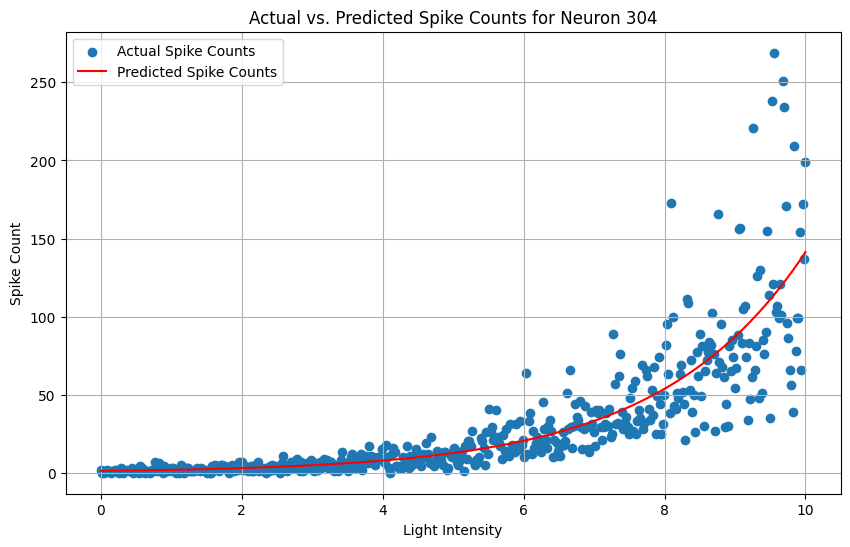

In [46]:
import statsmodels.api as sm

# Fit Negative Binomial GLM for each neuron
predicted_spike_counts = np.zeros((n_neurons, n_obs))

for i in range(n_neurons):
    # Create a DataFrame with the light intensity as the predictor variable
    data = pd.DataFrame({'light_intensity': light_intensity, 'spike_count': spike_counts[i, :]})
    
    # Fit Negative Binomial GLM
    model = sm.GLM(data['spike_count'], sm.add_constant(data['light_intensity']), family=sm.families.NegativeBinomial(alpha=1/nb_dispersion))
    results = model.fit()
    
    # Predict spike counts based on the fitted model
    predicted_spike_counts[i, :] = results.predict()

# Plot actual vs. predicted spike counts for a random neuron
neuron_idx = np.random.randint(0, n_neurons)

plt.figure(figsize=(10, 6))
plt.scatter(light_intensity, spike_counts[neuron_idx, :], label='Actual Spike Counts')
plt.plot(light_intensity, predicted_spike_counts[neuron_idx, :], color='red', label='Predicted Spike Counts')
plt.xlabel('Light Intensity')
plt.ylabel('Spike Count')
plt.title(f'Actual vs. Predicted Spike Counts for Neuron {neuron_idx}')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:            spike_count   No. Observations:                  500
Model:                            GLM   Df Residuals:                      498
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2090.5
Date:                Fri, 03 May 2024   Deviance:                       96.892
Time:                        12:09:44   Pearson chi2:                     76.4
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5684
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3060      0.137      2.235      0.025       0.038       0.574
light_intensity     0.4998      0.023     21.610      0.000       0.454       0.545
===================================================================================
"""

In [51]:
from scipy.special import gammaln, expit
from scipy.optimize import minimize

def neg_binomial_loglik(params, X, y):
    beta = params[:-1]
    alpha = params[-1]
    
    alpha = np.exp(alpha)
    
    mu = expit(X @ beta)
        
    term1 = gammaln(y + alpha) - gammaln(alpha) - gammaln(y + 1)
    term2 = (alpha) * np.log(alpha / (alpha + mu))
    term3 = y * np.log(mu / (alpha + mu))
    
    return -np.sum(term1 + term2 + term3)

def fit_model(X, y):
    # Initial guess for parameters
    init_params = np.append(np.zeros(X.shape[0]), 1) # Last one is log(alpha)

    # Minimize the negative log likelihood
    result = minimize(neg_binomial_loglik, init_params, args=(X, y))

    if result.success:
        fitted_params = result
        print("Model fitted successfully.")
    else:
        fitted_params = result
        print("Failed fitting")

    return result

In [52]:
params_please = fit_model(light_intensity, spike_counts)

Model fitted successfully.


In [54]:
values = params_please.x

In [55]:
values[-1]

-3.5537090770712294

In [56]:
params_please

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -55185434.22701805
        x: [ 0.000e+00  1.552e-04 ...  7.745e-02 -3.554e+00]
      nit: 11
      jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  1.000e+00 ... -1.201e-05  9.811e-13]
            ...
            [ 0.000e+00 -1.201e-05 ...  9.940e-01  4.896e-10]
            [ 0.000e+00  9.811e-13 ...  4.896e-10  3.020e-06]]
     nfev: 6024
     njev: 12

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)  # For reproducibility

# Parameters
n_neurons = 100  # Number of neurons
n_obs = 500  # Number of observations (different stimulus intensities)

# Stimulus variable: Light intensity ranging from 0 (no light) to 10 (maximum intensity)
light_intensity = np.linspace(0, 10, n_obs)

# Define relationship for expected spike count
# Assume the mean spike count increases linearly with the intensity of the light
beta_0 = 0  # Baseline spike count when there is no light
beta_1 = 0.3  # Increase in spike count for each unit increase in light intensity

# Define the dispersion parameter for the negative binomial distribution
dispersion = 50 # This affects the variance of the spike counts

samples_per_condition = 1000

spike_counts = np.zeros((n_neurons, n_obs))

for i in range(n_neurons):
    individual_effect = np.random.normal(0, 0.5)  # Random effect for each neuron
    
    # Calculate mean spike count using an exponential function to ensure non-negativity
    mean_spike_count = np.exp(beta_0 + beta_1 * light_intensity + individual_effect)
    
    # Calculate probability of success
    p = dispersion / (dispersion + mean_spike_count)  
    
    # Sample multiple times per condition
    for _ in range(samples_per_condition):
        spike_counts[i, :] += np.random.negative_binomial(n=dispersion, p=1-p, size=n_obs)
    
spike_counts /= samples_per_condition  # Average out the samples
    
# Calculate mean and variance for each neuron
mean_counts = np.mean(spike_counts, axis=1)
var_counts = np.var(spike_counts, axis=1)

# Plotting Mean vs. Variance
plt.figure(figsize=(10, 6))

# find dispersion parameter of the dataset
true_dispersion = (mean_counts ** 2) / (var_counts - mean_counts)
true_dispersion = true_dispersion.mean()

# use original dispersion parameter
nb_dispersion = dispersion
mu_values = np.linspace(0, np.max(mean_counts)*1.4, 300)
p = nb_dispersion / (nb_dispersion + mu_values)
expected_variance = nb_dispersion*(1-p)/p**2
plt.plot(mu_values, expected_variance, 'r--', label='Theoretical variance (Negative Binomial)')

# Theoretical variance curve for Poisson distribution
expected_variance_poisson = mu_values
plt.plot(mu_values, expected_variance_poisson, 'g--', label='Theoretical variance (Poisson)')

plt.scatter(mean_counts, var_counts, alpha=0.6)
plt.title('Mean vs. Variance of Spike Counts for Each Neuron')
plt.xlabel('Mean Spike Count')
plt.ylabel('Variance of Spike Count')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
Xw_NB = X_augmented @ NB_GLM_mle[:-1] # Assuming last two parameters are intercept and dispersion

# Function to compute the average spike count per bin
def compute_avg_spike_per_bin(Xw, Y, num_bins):
    bin_counts, bin_edges = np.histogram(Xw, bins=num_bins)
    bin_indices = np.digitize(Xw, bin_edges)
    avg_spike_count = [Y[bin_indices == i].mean() if np.any(bin_indices == i) else 0 for i in range(1, len(bin_edges))]
    # avg_spike_count = np.array([Y[bin_indices == i].mean() for i in range(1, len(bin_edges))])
    return bin_edges, avg_spike_count

# Compute average spike count per bin
num_bins = 25
bin_edges_NB, avg_spike_NB = compute_avg_spike_per_bin(Xw_NB, Y, num_bins)

# Calculate the parametric nonlinearity output for negative binomial (logistic link)
p_success = 1 / (1 + np.exp(-Xw_NB))  # Logistic function
r = np.exp(NB_GLM_mle[-1])  # Dispersion parameter
expected_spike_count = r * np.exp(Xw_NB)  # Mean calculation for negative binomial

# Create scatter plots
plt.figure(figsize=(12, 6))

# Negative Binomial Nonlinearity
plt.scatter(Xw_NB, expected_spike_count * dtStim, label='Parametric: Expected Spike Count', s=1)
plt.scatter(bin_edges_NB[:-1], avg_spike_NB, color='r', label='Nonparametric', s=10)
plt.xlabel('Stimulus Filter Output')
plt.ylabel('Expected Spike Count (spikes/bin)')
plt.title('Negative Binomial Nonlinearity')
plt.legend()

plt.tight_layout()
plt.show()